## InceptionNet
### Effects of Occlusion of input images


Inception, introduced by Google's team, is a deep convolutional neural network. This notebook is inspired by this inception architecture.


Reference: C. Szegedy et al., "Going deeper with convolutions,"

In [1]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import os

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
device

device(type='cuda')


CIFAR-10 is a popular dataset used for training machine learning models, consisting of 60,000 32x32 color images in 10 different classes. In this section, we will load the CIFAR-10 dataset using TensorFlow and PyTorch. The dataset is split into 50,000 training images and 10,000 test images.


# Grid-based Occlusion
Inspired by: *Hide-and-Seek: A Data Augmentation Technique for Weakly-Supervised Localization and Beyond, Krishna Kumar Singh et al.*

I designed a simple algorithm that applies grid based random cutout of multiple patches in an image.

In [3]:


def grid_occlusion(img, grid_size, drop_prob):
    _, h, w = img.shape
    mask = torch.ones((h, w))

    for i in range(0, h, grid_size):
        for j in range(0, w, grid_size):
            if torch.rand(1).item() < drop_prob:
                mask[i:i+grid_size, j:j+grid_size] = 0

    img = img * mask
    return img

class GridOcclusionTransform:
    def __init__(self, grid_size=4, drop_prob=0.2):
        self.grid_size = grid_size
        self.drop_prob = drop_prob

    def __call__(self, img):
        return grid_occlusion(img, self.grid_size, self.drop_prob)


def data_loader(data_dir,
                    batch_size,
                    random_seed=42,
                    valid_size=0.1,
                    shuffle=True,
                    test=False):

        normalize = transforms.Normalize(
            mean=[0.4914, 0.4822, 0.4465],
            std=[0.2023, 0.1994, 0.2010],
        )

        # define transforms
        transform = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            GridOcclusionTransform(),
            normalize,
        ])
        transform_test = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            GridOcclusionTransform(),

            normalize,
        ])
        download = not os.path.exists(os.path.join(data_dir, "cifar-10-batches-py"))
        print(download)
        if test:
            dataset = datasets.CIFAR10(
              root=data_dir, train=False,
              download=download, transform=transform_test,
            )

            data_loader = torch.utils.data.DataLoader(
                dataset, batch_size=batch_size, shuffle=shuffle
            )

            return data_loader

        # load the dataset
        train_dataset = datasets.CIFAR10(
            root=data_dir, train=True,
            download=download, transform=transform,
        )


        num_train = len(train_dataset)
        indices = list(range(num_train))
        split = int(np.floor(valid_size * num_train))

        if shuffle:
            np.random.seed(42)
            np.random.shuffle(indices)

        train_idx, valid_idx = indices[split:], indices[:split]
        train_sampler = SubsetRandomSampler(train_idx)
        valid_sampler = SubsetRandomSampler(valid_idx)

        train_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=batch_size, sampler=train_sampler,num_workers=2,pin_memory=True)

        valid_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=batch_size, sampler=valid_sampler)

        return (train_loader, valid_loader)
train_loader, valid_loader = data_loader(data_dir='/kaggle/working/cifar10',
                                             batch_size=128)

test_loader = data_loader(data_dir='/kaggle/working/cifar10',
                                  batch_size=128,
                                  test=True)

True


100%|██████████| 170498071/170498071 [00:20<00:00, 8276050.64it/s] 


Extracting /kaggle/working/cifar10\cifar-10-python.tar.gz to /kaggle/working/cifar10
False


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4290657..2.3804553].


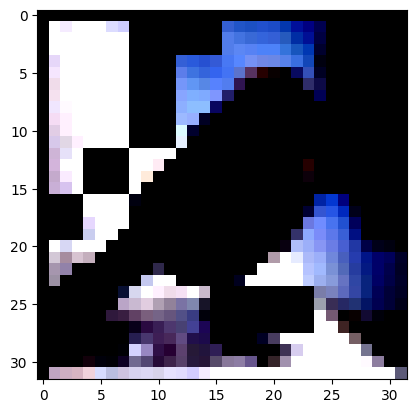

In [6]:
image, labels = next(iter(test_loader))
plt.imshow(image[116].permute(1,2,0))

### InceptionNet adopted from our earlier challenges on Quantization

In [9]:
import torch
import torch.nn as nn

class InceptionNet(nn.Module):
    def __init__(self, num_classes=10):
        super(InceptionNet, self).__init__()
        self.in_channels = 3


        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1, stride=1)
        self.bn1_1 = nn.BatchNorm2d(64)
        self.relu1_1 = nn.ReLU(inplace=True)


        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding='same')
        self.bn1_2 = nn.BatchNorm2d(64)
        self.relu1_2 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)


        #block1

        #1X1
        #for 3x3
        self.conv2_1 = nn.Conv2d(64, 32, kernel_size=1, padding='same')
        self.bn2_1 = nn.BatchNorm2d(32)
        self.relu2_1 = nn.ReLU(inplace=True)

        #for 5x5
        self.conv2_2 = nn.Conv2d(64, 8, kernel_size=1, padding='same')
        self.bn2_2 = nn.BatchNorm2d(8)
        self.relu2_2 = nn.ReLU(inplace=True)



        #maxpool
        self.pool2_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)

        #3x3
        self.conv2_4 = nn.Conv2d(32, 64, kernel_size=3, padding='same')
        self.bn2_4 = nn.BatchNorm2d(64)
        self.relu2_4 = nn.ReLU(inplace=True)

        #5x5
        self.conv2_5 = nn.Conv2d(8, 16, kernel_size=5, padding='same')
        self.bn2_5 = nn.BatchNorm2d(16)
        self.relu2_5 = nn.ReLU(inplace=True)

        #for 1x1
        self.conv2_3 = nn.Conv2d(64, 32, kernel_size=1, padding='same')
        self.bn2_3 = nn.BatchNorm2d(32)
        self.relu2_3 = nn.ReLU(inplace=True)

        #after maxpool
        self.conv2_6 = nn.Conv2d(64, 16, kernel_size=1, padding='same')
        self.bn2_6 = nn.BatchNorm2d(16)
        self.relu2_6 = nn.ReLU(inplace=True)


        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        #block2

        #1X1
        #for 3x3
        self.conv3_1 = nn.Conv2d(128, 64, kernel_size=1, padding='same')
        self.bn3_1 = nn.BatchNorm2d(64)
        self.relu3_1 = nn.ReLU(inplace=True)

        #for 5x5
        self.conv3_2 = nn.Conv2d(128, 16, kernel_size=1, padding='same')
        self.bn3_2 = nn.BatchNorm2d(16)
        self.relu3_2 = nn.ReLU(inplace=True)

        #for 1x1
        self.conv3_3 = nn.Conv2d(128, 64, kernel_size=1, padding='same')
        self.bn3_3 = nn.BatchNorm2d(64)
        self.relu3_3 = nn.ReLU(inplace=True)

        #maxpool
        self.pool3_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)

        #3x3
        self.conv3_4 = nn.Conv2d(64, 128, kernel_size=3, padding='same')
        self.bn3_4 = nn.BatchNorm2d(128)
        self.relu3_4 = nn.ReLU(inplace=True)

        #5x5
        self.conv3_5 = nn.Conv2d(16, 32, kernel_size=5, padding='same')
        self.bn3_5 = nn.BatchNorm2d(32)
        self.relu3_5 = nn.ReLU(inplace=True)

        #after maxpool
        self.conv3_6 = nn.Conv2d(128, 32, kernel_size=1, padding='same')
        self.bn3_6 = nn.BatchNorm2d(32)
        self.relu3_6 = nn.ReLU(inplace=True)


        #final averagePool
        self.avg_pool = nn.AvgPool2d(kernel_size=8, stride=2)

        self.fc1 = nn.Linear(256, 2048)
        self.relu_fc1 = nn.ReLU(inplace=True)
        # self.fc2 = nn.Linear(4096, 4096)
        # self.relu_fc2 = nn.ReLU(inplace=True)
        self.fc3 = nn.Linear(2048, num_classes)


        self._initialize_weights()

    def forward(self, x):
      x = self.relu1_1(self.bn1_1(self.conv1_1(x)))
      x = self.relu1_2(self.bn1_2(self.conv1_2(x)))
      x = self.pool1(x)

      x_3x3 = self.relu2_1(self.bn2_1(self.conv2_1(x)))
      x_5x5 = self.relu2_2(self.bn2_2(self.conv2_2(x)))
      x_1x1 = self.relu2_3(self.bn2_3(self.conv2_3(x)))
      x_pool = self.pool2_1(x)

      x_3x3 = self.relu2_4(self.bn2_4(self.conv2_4(x_3x3)))
      x_5x5 = self.relu2_5(self.bn2_5(self.conv2_5(x_5x5)))
      x_pool = self.relu2_6(self.bn2_6(self.conv2_6(x_pool)))

      x = torch.cat([x_1x1, x_3x3, x_5x5, x_pool], dim=1)
      x = self.maxpool(x)

      x_3x3 = self.relu3_1(self.bn3_1(self.conv3_1(x)))
      x_5x5 = self.relu3_2(self.bn3_2(self.conv3_2(x)))
      x_1x1 = self.relu3_3(self.bn3_3(self.conv3_3(x)))
      x_pool = self.pool3_1(x)

      x_3x3 = self.relu3_4(self.bn3_4(self.conv3_4(x_3x3)))
      x_5x5 = self.relu3_5(self.bn3_5(self.conv3_5(x_5x5)))
      x_pool = self.relu3_6(self.bn3_6(self.conv3_6(x_pool)))

      x = torch.cat([x_1x1, x_3x3, x_5x5, x_pool], dim=1)
      x = self.avg_pool(x)

      x = x.view(x.size(0), -1)
      x = self.relu_fc1(self.fc1(x))
      x = self.fc3(x)

      return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


In [10]:
num_classes = 10
num_epochs = 10
learning_rate = 0.075

model = InceptionNet()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0.001, momentum=0.9)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,
                                               milestones=[4,8],
                                               gamma=0.1)

total_step = len(train_loader)

In [11]:
from google.colab import drive
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
drive.mount('/content/drive')

Mounted at /content/drive


The training loop includes model checkpointing, which saves the model, optimizer, and scheduler states every two epochs to allow resuming training if interrupted. It also implements early stopping based on validation accuracy, halting training after three consecutive epochs of no improvement. Additionally, the loop ensures efficient memory management by clearing tensors and invoking garbage collection after each batch.

We only use 10 epoches considering resource constraints.

In [ ]:
import gc
import time

checkpoint_path = "/content/drive/MyDrive/here.pth" #to reuse old weights(optional)



if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint["model_state"])
    optimizer.load_state_dict(checkpoint["optimizer_state"])
    scheduler.load_state_dict(checkpoint["scheduler_state"])
    start_epoch = checkpoint["epoch"] + 1
    print(f"Checkpoint loaded. Resuming from epoch {start_epoch}")


start_epoch = 0
total_step = len(train_loader)
best_val = -1
tolerance = 3
t = 0
loss_info = {'train':[], 'val':[]}
for epoch in range(start_epoch, num_epochs):
    t = time.time()
    for i, (images, labels) in enumerate(train_loader):
        # if total_step/2 == i+1:
        #   print("half way there")
        #Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        #Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        #Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        del images, labels, outputs
        torch.cuda.empty_cache()
        gc.collect()
    scheduler.step()
    if (epoch + 1) % 2 == 0:
        torch.save({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "scheduler_state":scheduler.state_dict()
        }, os.path.join(os.path.dirname(checkpoint_path), f"inception_occlusion_{epoch+1}.pth"))
        print(f"Checkpoint saved at epoch {epoch+1}")
    print ('epoch {}, Train loss: {:.4f}'.format(epoch+1, loss.item()))
    print("Time: {:.2f}".format( time.time()-t))
    loss_info['train'].append(loss.item())

    # Validation
    with torch.no_grad():
        correct = 0
        total = 0
        loss_total = 0
        batch_size = 0
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            loss_total += loss.item()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            batch_size+=1

        loss_avg = loss_total/batch_size
        val_acc = 100 * correct / total
        print(f'Val acc: {val_acc:.2f}%    Val loss: {loss_avg: .2f}')
        loss_info['val'].append(loss_avg)


    if epoch > 0 and val_acc <= best_val:
        tolerance -= 1
        if tolerance == 0:
            print("early stopping")
            break
    else:
        best_val = val_acc
        tolerance = 3

epoch 1, Train loss: 1.6255
Time: 100.67
Val acc: 43.20%    Val loss:  1.50
Checkpoint saved at epoch 2
epoch 2, Train loss: 1.3581
Time: 102.97
Val acc: 52.66%    Val loss:  1.28
epoch 3, Train loss: 1.0229
Time: 101.53
Val acc: 59.30%    Val loss:  1.12
Checkpoint saved at epoch 4
epoch 4, Train loss: 1.1329
Time: 101.08
Val acc: 62.32%    Val loss:  1.03
epoch 5, Train loss: 0.8890
Time: 101.34
Val acc: 69.86%    Val loss:  0.84
Checkpoint saved at epoch 6
epoch 6, Train loss: 0.6664
Time: 100.31
Val acc: 70.60%    Val loss:  0.82
epoch 7, Train loss: 1.1238
Time: 100.61
Val acc: 71.28%    Val loss:  0.80
Checkpoint saved at epoch 8
epoch 8, Train loss: 1.0061
Time: 100.26
Val acc: 72.40%    Val loss:  0.78
epoch 9, Train loss: 0.5084
Time: 100.64
Val acc: 73.48%    Val loss:  0.76
Checkpoint saved at epoch 10
epoch 10, Train loss: 0.7457
Time: 102.15
Val acc: 73.58%    Val loss:  0.76


### Loss curve

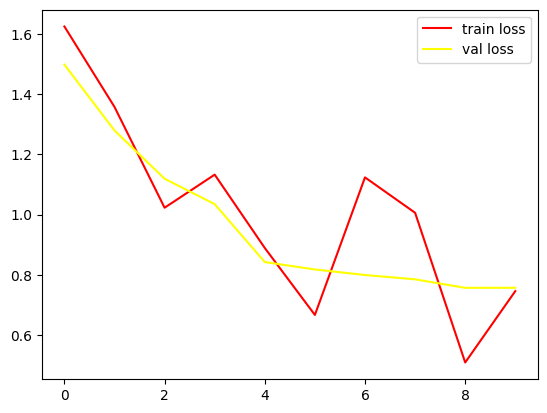

In [85]:
plt.plot(range(len(loss_info['train'])), loss_info['train'], color='red', label='train loss')
plt.plot(range(len(loss_info['val'])), loss_info['val'], color='yellow', label='val loss')

plt.legend()

plt.show()

In [ ]:
import seaborn as sns

from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_true, y_pred, class_labels):
      cm = confusion_matrix(y_true, y_pred)
      plt.figure(figsize=(8, 6))
      sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
      plt.xlabel('Predicted Label')
      plt.ylabel('True Label')
      plt.show()


### Check Original Model
We first test older model weights to analyze robustness on altered images. This model was trained on clean non-altered images.

Accuracy 37.37%


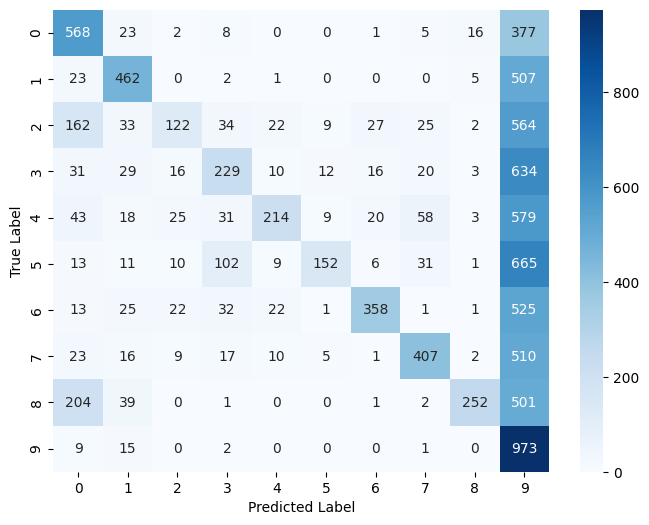

In [18]:
y_pred = []
y_true = []
model.eval()

#pretrained model on non-occluded images
checkpoint_path = "/content/inception_10 (1).pth"

if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location='cpu')
    model.load_state_dict(checkpoint["model_state"])
    optimizer.load_state_dict(checkpoint["optimizer_state"])
    scheduler.load_state_dict(checkpoint["scheduler_state"])
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        model.to(device)
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del images, labels, outputs

print('Accuracy {}%'.format(100 * correct / total))
plot_confusion_matrix(y_true, y_pred, range(0,10))


### Check our new model

Accuracy 73.35%


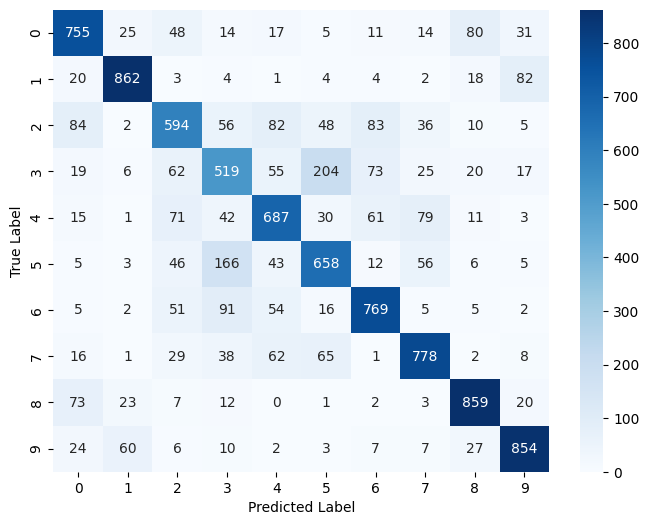

In [17]:
y_pred = []
y_true = []
model.eval()
checkpoint_path = "/content/drive/MyDrive/inception_occlusion_10.pth"

if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location='cpu')
    model.load_state_dict(checkpoint["model_state"])
    optimizer.load_state_dict(checkpoint["optimizer_state"])
    scheduler.load_state_dict(checkpoint["scheduler_state"])
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        model.to(device)
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del images, labels, outputs

print('Accuracy {}%'.format(100 * correct / total))
plot_confusion_matrix(y_true, y_pred, range(0,10))


# Scores

#### First, we check the original model's behaviour
$$
\text{Pure Model Robustness} = \frac{\text{Accuracy on occluded images}}{\text{Accuracy on non-occluded images}}=37.37 / 80.58 = 0.463
$$




#### Now, we check the newly trained model's improvement compared to original
$$
\text{Trained Model Robustness Improvement} = \frac{\text{New model accuracy on occluded images}}{\text{Old model accuracy on occluded images}}= 73.35 / 37.37 = 1.962
$$

